In [802]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
import sys
from scipy import stats
import copy
sys.path.append('/Users/gfabbian/Software/PolSpice_v03-07-05/bin')
rot = hp.Rotator(coord=['C','G'])

# Preparing data

### Masks
Reads and rotate QSO masks, selection function in galactic coordinates. Read Planck masks

In [290]:
binmask_c = hp.read_map('../../mask_qso_binary_mcs_dust_Av0.2_NSIDE256.fits')
mask_c = hp.read_map('../../mask_qso_prob_NSIDE256.fits')
mask = rot.rotate_map_pixel(mask_c)
binmask = rot.rotate_map_pixel(binmask_c)

# define selection function mask
inv_mask_c = 1/mask_c
inv_mask_c[mask_c==0]= 0.
inv_mask_g = rot.rotate_map_pixel(inv_mask_c)
inv_mask_g[inv_mask_g<1e-05] = 0

/var/folders/3c/k4c228y17_b7sq_m4m7gy8w80000gq/T/ipykernel_52416/750813109.py:6: RuntimeWarning: divide by zero encountered in divide
  inv_mask_c = 1/mask_c


In [442]:
# read files
try:
    lensmask = hp.read_map('/Users/fabbian/Work/Planck/DR3/COM_Lensing-CIBcomb_2000_R3.00/inputs/mask.fits')
    galmask40 = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
    galmask = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)    
    galmask70 = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=3)        
except:
    lensmask = hp.read_map('/Users/gfabbian/Work/PR4_variations/mask.fits')
    galmask40 = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
    galmask = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)  
    galmask70 = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=3)      
     


In [600]:
# degrade masks 
lensmask_lr = hp.ud_grade(lensmask,nside_out=nside)
lensmask_lr[lensmask_lr!=0]=1.

galmask70_lr = hp.ud_grade(galmask70,nside_out=nside)
galmask70_lr[galmask70_lr!=0]=1.

galmask_lr = hp.ud_grade(galmask,nside_out=nside)
galmask_lr[galmask_lr!=0]=1.

galmask40_lr = hp.ud_grade(galmask40,nside_out=nside)
galmask40_lr[galmask40_lr!=0]=1.


# create fsky 50% mask
testmask = nmt.mask_apodization(galmask_lr,15, apotype="C1")
galmask50_lr = np.array(testmask)
#threshold= 0.5 #for apo 10
threshold= 0.3
galmask50_lr[testmask<threshold]=0.
galmask50_lr[testmask>threshold]=1

binmask[binmask!=0]=1

### Resolution

Define resolution parameter for projections etc.

In [602]:
nside=256
beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)

### Lensing

Read data and filter maps to match $\ell_{max}$ set by nside parameter of HEALPIX grid

In [603]:
# compute delta  and k

klm = hp.read_alm('../../dat_klm.fits')
klm = hp.read_alm('/Users/gfabbian/Work/PR4_variations/PR42018like_klm_dat_MV.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[3*nside-1:]=0.
khr=hp.alm2map(hp.almxfl(klm,fl),nside=2048,pol=False)

### QSO

Read catalog , convert position to galactic coordinates. 

In [604]:
# Prepare raw GAIA data
print("Read catalog and convert coordinate")
d=fits.open('../../gaia_G20.0.fits')

sc = SkyCoord(ra=d[1].data["ra"], dec=d[1].data["dec"], unit='deg', frame='icrs', equinox='J2000.0')
gs = sc.transform_to(frame='galactic')

l_hp,b_hp = rot(d[1].data['ra'],d[1].data['dec'],lonlat=True)
l_hp[l_hp<0] = 360+l_hp[l_hp<0]
print("Galactic coordinate conversion astropy vs catalog rms delta_l %.4farcsec rms delta_b %.4farcsec"%(np.std(
    gs.l.value-d[1].data['l'])*3600,np.std(gs.b.value-d[1].data['b'])*3600))
print("Galactic coordinate conversion healpy  vs catalog rms delta_l %.4farcsec rms delta_b %.4farcsec"%(np.std(
    l_hp-d[1].data['l'])*3600,np.std(b_hp-d[1].data['b'])*3600))

Read catalog and convert coordinate
Galactic coordinate conversion astropy vs catalog rms delta_l 0.0316arcsec rms delta_b 0.0076arcsec
Galactic coordinate conversion healpy  vs catalog rms delta_l 0.0221arcsec rms delta_b 0.0041arcsec


Project galaxy on sky and compute counts in pixels. 
then compute the density contrast using the mean of object computed over the footprint.  Then corrects counts by the selection function multiplying by the inverse probability before computing the overdensity.

Finally define splits for computing jackknife.

In [704]:
def make_counts(nside,l,b):
    counts=np.zeros(hp.nside2npix(nside))
    pix = hp.ang2pix(nside,l,b,lonlat=True)
    for p in pix:
        counts[p]+=1    
    return counts

m=make_counts(nside,gs.l.value,gs.b.value)
m1=make_counts(nside,gs.l.value[0::2],gs.b.value[0::2])
m2=make_counts(nside,gs.l.value[1::2],gs.b.value[1::2])

# the survey above is for ~50% of the sky. 
# compute correction of counts by probability density. 
msel=np.zeros(hp.nside2npix(nside))
msel[binmask!=0] = m[binmask!=0]*inv_mask_g[binmask!=0]

In [606]:
nbar_sel = np.mean(msel[binmask!=0])

nbar_full = np.mean(m[m!=0])
nbar_full_fsky50 = np.mean(m[galmask50_lr!=0])

nbar_full_sel = np.mean(msel[m!=0])

nbar = np.mean(m[binmask!=0])
c = m/nbar_sel -1
csel = msel/nbar_sel -1

nbar1 = np.mean(m1[binmask!=0])
c1 = m1/nbar1 -1

nbar2 = np.mean(m2[binmask!=0])
c2 = m2/nbar2 -1

jk =(c2-c1)/2
print("Stats on Kate's mask")
print("nbar        ",nbar,"mean/std counts map",np.mean(m),np.std(m))
print("nbar selfun.",nbar_sel,"mean/std counts map",np.mean(msel),np.std(msel))
print("nbar1       ",nbar1,"mean/std counts map",np.mean(m1),np.std(m1))
print("nbar2       ",nbar2,"mean/std counts map",np.mean(m2),np.std(m2))
print()
print("Stats on sky counts !=0")
print("nbar        ",nbar_full)
print("nbar fsky=50",nbar_full2)
print("nbar selfun.",nbar_full_sel)

Stats on Kate's mask
nbar         1.2225455565615475 mean/std counts map 0.8250452677408854 1.0337500142615053
nbar selfun. 1.243099102737518 mean/std counts map 0.6197776065672138 1.0365438031703522
nbar1        0.6112115686249506 mean/std counts map 0.4125226338704427 0.6362952269593365
nbar2        0.611333987936597 mean/std counts map 0.4125226338704427 0.6375888683705065

Stats on sky counts !=0
nbar         1.6440989334826643
nbar fsky=50 1.2208661305813255
nbar selfun. 1.235054295558502


### Plotting

Displays data, footprint and redshift properties of catalog

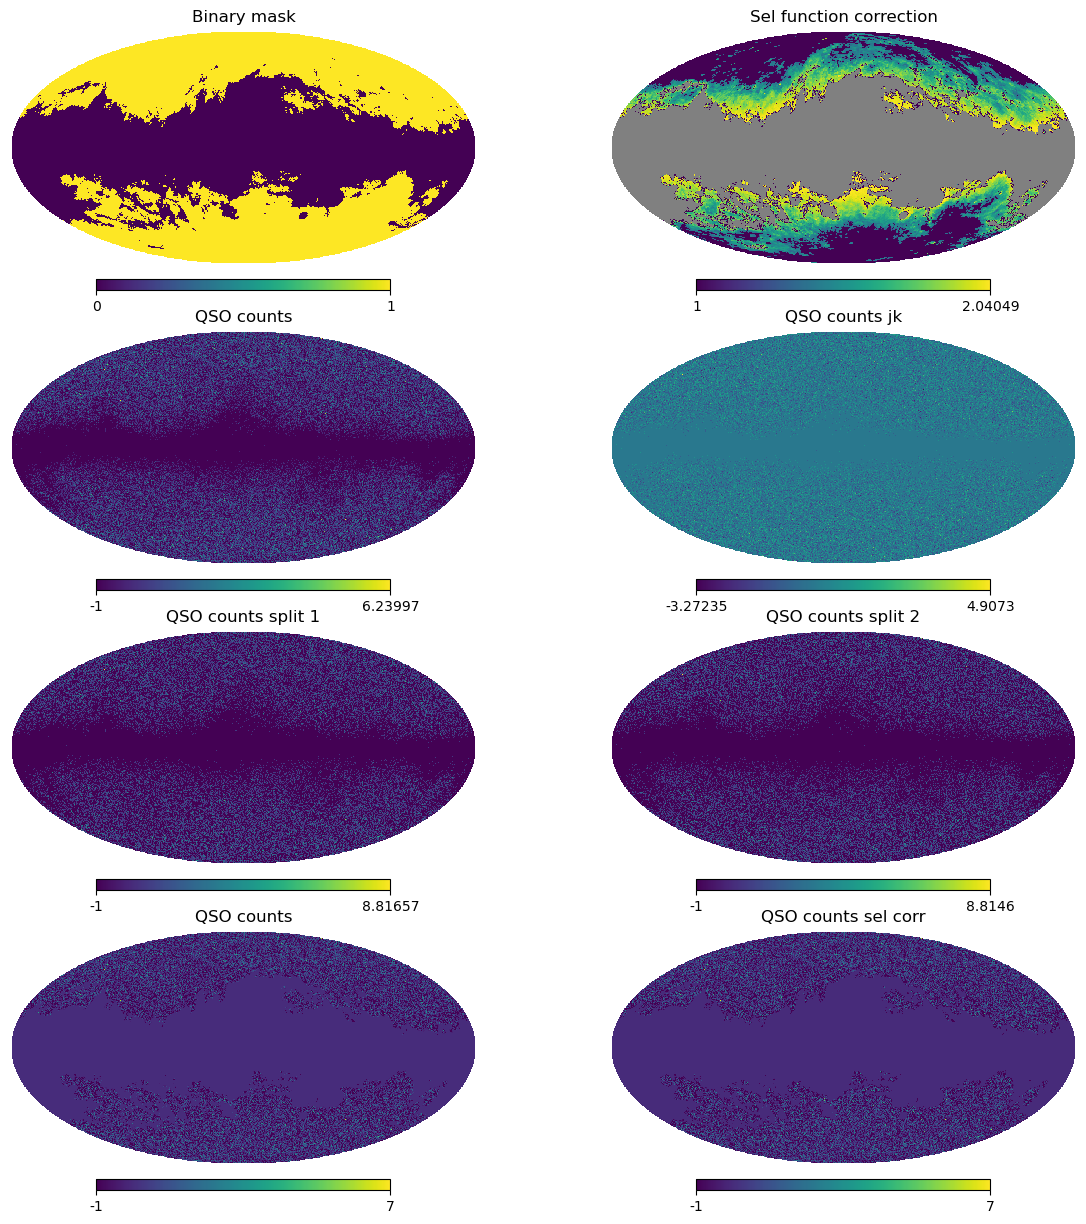

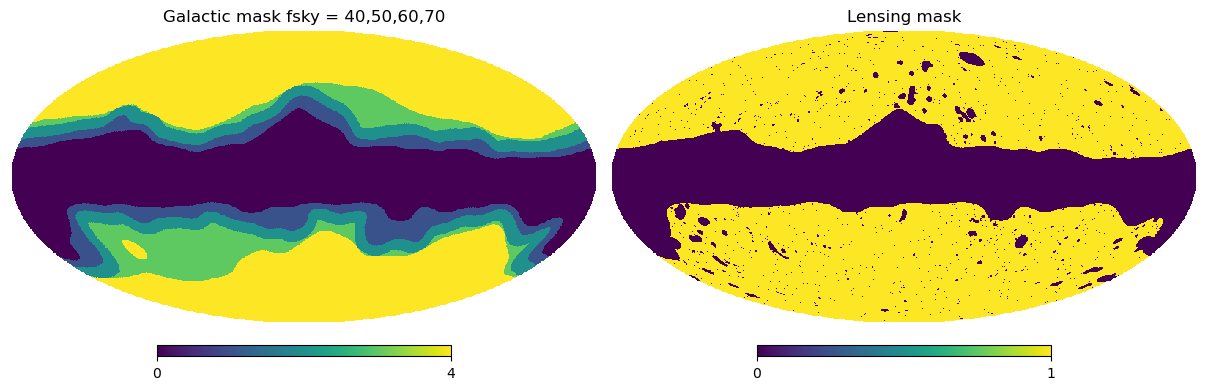

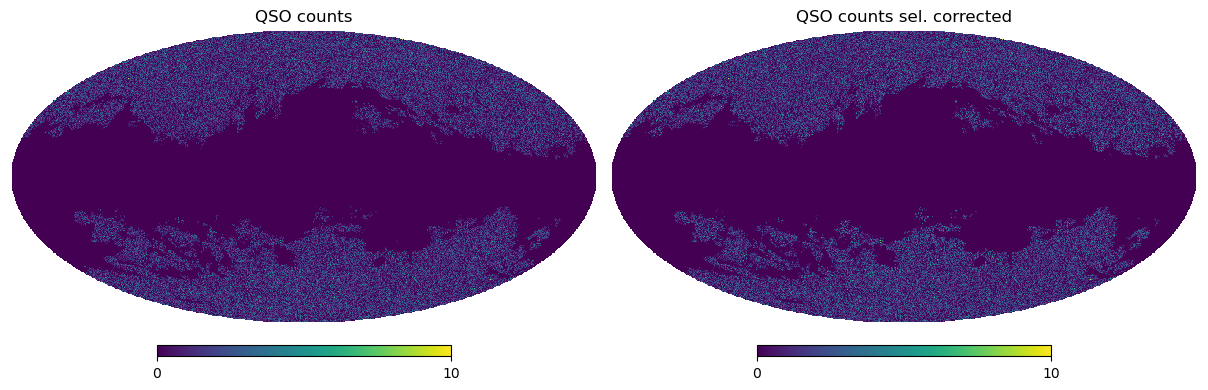

In [608]:
inv_mask_g_plot = np.array(inv_mask_g)
inv_mask_g_plot[inv_mask_g_plot==0]=hp.UNSEEN
pl.figure(figsize=(12,12))
hp.mollview(binmask,sub=421,title='Binary mask')
hp.mollview(inv_mask_g_plot,sub=422,title='Sel function correction',min=1,norm='hist')
hp.mollview(c,sub=423,title='QSO counts')
hp.mollview(jk,sub=424,title='QSO counts jk')
hp.mollview(c1,sub=425,title='QSO counts split 1')
hp.mollview(c2,sub=426,title='QSO counts split 2')
hp.mollview(c*binmask,sub=427,title='QSO counts',min=-1,max=7)
hp.mollview(csel*binmask,sub=428,title='QSO counts sel corr',min=-1,max=7)
pl.show()


pl.figure(figsize=(12,4))
hp.mollview(galmask_lr+galmask70_lr+galmask40_lr+galmask50_lr,sub=121,title='Galactic mask fsky = 40,50,60,70')
hp.mollview(lensmask,sub=122,title='Lensing mask')
pl.show()


pl.figure(figsize=(12,4))
hp.mollview(m*binmask,sub=121,title='QSO counts',max=10)
hp.mollview(msel*binmask,sub=122,title='QSO counts sel. corrected',max=10)
pl.show()

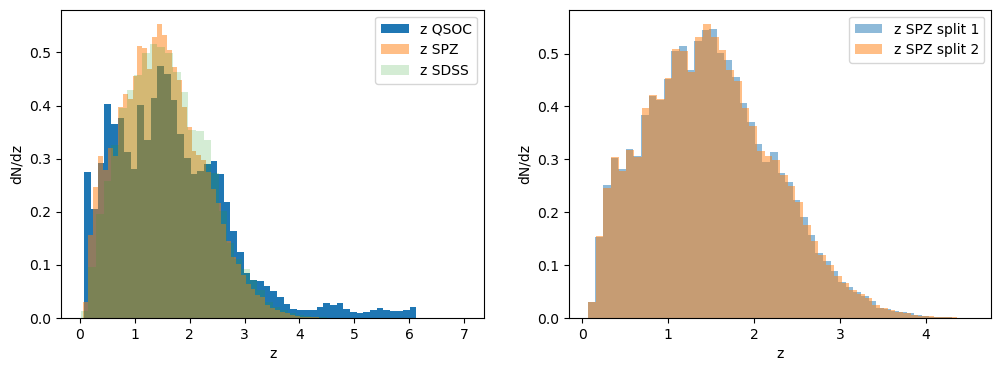

In [559]:
pl.figure(figsize=(12,4))
pl.subplot(1,2,1)
dndz_qsoc= pl.hist(d[1].data['redshift_qsoc'],bins=50,density=True,label='z QSOC')
dndz_spz= pl.hist(d[1].data['redshift_spz'],bins=50,density=True,alpha=0.5,label='z SPZ')
dndz_sdss= pl.hist(d[1].data['redshift_sdss'],bins=50,density=True,alpha=0.2,label='z SDSS')
pl.legend()
pl.xlabel('z')
pl.ylabel('dN/dz')
pl.subplot(1,2,2)
pl.hist(d[1].data['redshift_spz'][0::2],bins=50,density=True,alpha=0.5,label='z SPZ split 1')
pl.hist(d[1].data['redshift_spz'][1::2],bins=50,density=True,alpha=0.5,label='z SPZ split 2')
pl.xlabel('z')
pl.ylabel('dN/dz')
pl.legend()
pl.show()

# Theory model

Use $dN/dz$ to compute theory model using CAMB. Bias adopted from https://arxiv.org/pdf/1705.04718.pdf . In this model the median redshift of our sample should give a bias of around $b=2.45$

In [894]:
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

def init_pars():

    pars = camb.CAMBparams()
    lmax=1000
    b_quasar=2.35
    
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0)
    pars.InitPower.set_params(As=2e-9, ns=0.965)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = True
    
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    
    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = 300
    pars.SourceTerms.counts_lensing = True
    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = True #weird problems at times
    pars.SourceTerms.counts_radial   = True # negligible at l<10
    pars.SourceTerms.counts_timedelay = True # negligible
    pars.SourceTerms.counts_ISW = True #negligible
    pars.SourceTerms.counts_velocity = True #negligible
    pars.SourceTerms.counts_potential = True #negligible
    pars.SourceTerms.counts_evolve = True # not sure what this is
    return pars 
pars = init_pars()
dndz= pl.hist(d[1].data['redshift_spz'],bins=50)
pl.close()
#dndz= pl.hist(d[1].data['redshift_qsoc'],bins=50)
dndz=[np.diff(dndz[1])+dndz[1][:-1],dndz[0]]

# read dn/dz and normalize it
dndz[1]/=np.trapz(dndz[1],dndz[0])
#pl.plot(dndz[0],dndz[1])

##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.
W=np.array(dndz[1])
z=np.array(dndz[0])
pars.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z)), z=z, W=W,source_type='counts')]

results = camb.get_results(pars)

# In the returned dictionary P is the lensing potential and not deflection as in camb doc if raw_cl=True. 
# potentially related to CAMB version and fixed in later ones?
cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')
cls = results.get_source_cls_dict(raw_cl=True) 



/var/folders/3c/k4c228y17_b7sq_m4m7gy8w80000gq/T/ipykernel_52416/1893565244.py:4: RuntimeWarning: divide by zero encountered in divide
  d2p=1/p2d
/var/folders/3c/k4c228y17_b7sq_m4m7gy8w80000gq/T/ipykernel_52416/1893565244.py:21: RuntimeWarning: invalid value encountered in divide
  rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))


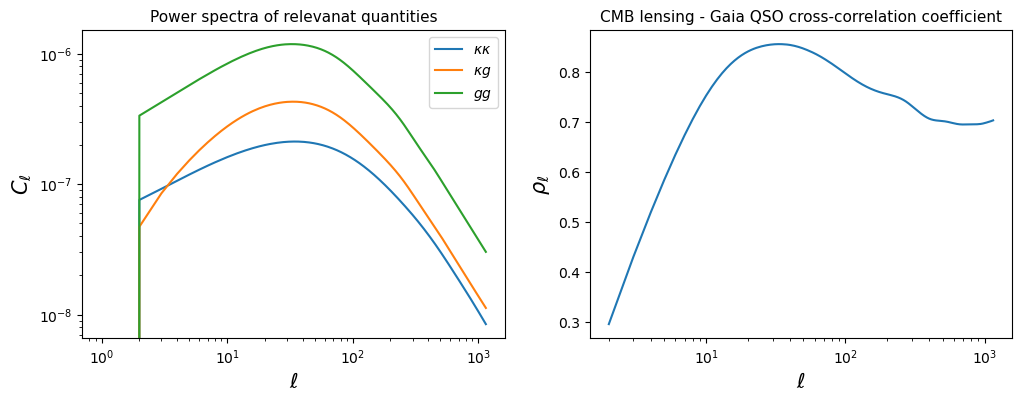

In [561]:
# plots power spectra
ls = np.arange(len(cls['PxP']))
p2d=np.sqrt(ls*(ls+1))
d2p=1/p2d
d2p[0:2]=0.0
d2k=p2d/2
p2k=(p2d**2/2)

pl.figure(figsize=(12,4))
pl.subplot(1,2,1)
pl.loglog(ls,cls['PxP']*p2k**2,label='$\kappa\kappa$')
pl.loglog(ls,cls['PxW1']*p2k,label='$\kappa g$') # should give kappaX for cross correlation
pl.loglog(ls,cls['W1xW1'],label='$gg$') 
pl.xlabel("$\ell$",size=15)
pl.ylabel("$C_\ell$",size=15)
pl.title("Power spectra of relevanat quantities",size=11)
pl.legend()


# compute correlation coefficient
rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))
pl.subplot(1,2,2)
pl.semilogx(ls,np.abs(rho))
pl.xlabel("$\ell$",size=15)
pl.ylabel("$\\rho_\ell$",size=15)
pl.title("CMB lensing - Gaia QSO cross-correlation coefficient",size=11)
pl.show()

# Power spectrum estimation NAMASTER

### Data preparation
Define low resolution masks, apodizes them, downgrade lensing map to match QSO map. 

In [581]:
#khr_cl = hp.anafast(khr,lmax=4096,iter=1,pol=False)
apomask = nmt.mask_apodization(binmask,0.5, apotype="C2")
apomask_gal = nmt.mask_apodization(galmask_lr,1, apotype="C2")
apomask_gal40 = nmt.mask_apodization(galmask40_lr,1, apotype="C2")
apomask_gal50 = nmt.mask_apodization(galmask50_lr,2, apotype="C2")


# add point source masks
ps_mask = 1#lensmask_lr
apomask_lens = nmt.mask_apodization(binmask*ps_mask,0.5, apotype="C2")
apomask_gal_lens = nmt.mask_apodization(galmask_lr*ps_mask,1, apotype="C2")
apomask_gal40_lens = nmt.mask_apodization(galmask40_lr*ps_mask,1, apotype="C2")
apomask_gal50_lens = nmt.mask_apodization(galmask50_lr*ps_mask,1, apotype="C2")

klr = hp.ud_grade(khr,nside_out=nside)


Define binning, pseudo-power specturmc omputation function and function to compute all relevant quantities for a given mask and binning scheme

In [582]:


delta_b=20
b = nmt.NmtBin.from_nside_linear(nside, delta_b,is_Dell=False)
lb = b.get_effective_ells()

def compute_master(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

def compute_master_crosscorr_mask(apodized_mask,binning):
    # corrects for pixel window function
    beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)
    
    f0 = nmt.NmtField(apodized_mask, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade

    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f0, f0, binning)    

    f1 = nmt.NmtField( apodized_mask, [c],beam=beam)
    f11 = nmt.NmtField(apodized_mask, [c1],beam=beam)
    f12 = nmt.NmtField(apodized_mask, [c2],beam=beam)
    fjk = nmt.NmtField(apodized_mask, [jk],beam=beam)
    
    clkg = compute_master(f0, f1, w)[0]
    clgg = compute_master(f1, f1, w)[0]
    clkk = compute_master(f0, f0, w)[0]
    
    clkg1 = compute_master(f0, f11, w)[0]
    clg1g1 = compute_master(f11, f11, w)[0]
    
    clkg2 = compute_master(f0, f12, w)[0]
    clg2g2 = compute_master(f12, f12, w)[0]
    
    
    clg1g2 = compute_master(f11, f12, w)[0]
    clkgjk = compute_master(f0, fjk, w)[0]
    clgjk = compute_master(fjk, fjk, w)[0]
    
    cl_gg_th_binned = w.decouple_cell(w.couple_cell([cls['W1xW1']]))[0]
    cl_kg_th_binned = w.decouple_cell(w.couple_cell([cls['PxW1']*p2k]))[0]
    cl_kk_th_binned = w.decouple_cell(w.couple_cell([hp.alm2cl(klm)]))[0]    
    return clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned


### Computation and plotting

In [583]:
analysis_mask = apomask_gal50 # avoids some of the auto correlation problem in bandpowers (more regular object)
clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned = compute_master_crosscorr_mask(analysis_mask,b)

In [800]:
def plot_summary(clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned,lb=lb,delta_b=delta_b,analysis_mask=analysis_mask,lmin=10):
    dkg = np.sqrt(clkk*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkg1 = np.sqrt(clkk*clg1g1 + clkg1**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkg2 = np.sqrt(clkk*clg2g2 + clkg2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkgjk = np.sqrt(clkk*clgjk)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkg_th = np.sqrt(cl_kk_th_binned*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    
    lbmin=1
    chi2=((clkg-cl_kg_th_binned)/dkg)[lbmin:]**2
    chi2null=(clkg/dkg)[lbmin:]**2
    chi2jk=(clkgjk/dkgjk)[lbmin:]**2
    dof = len(chi2) -1
    snr = np.sqrt(np.cumsum(chi2null)[-1])
    snrth = np.sqrt(np.cumsum(clkg**2/dkg_th**2)[-1]) # uses theory error bar and not data-based estimates
    significance = np.sqrt(np.sum(chi2null) - np.sum(chi2))
    print("lmin",lb[lbmin],"dof",dof,"chi2null/dof %.3f"%(np.sum(chi2null)/dof))
    print("kg snr %.3f"%snr,'snr [th errors] %.3f'%snrth)
    print("kg chi2/dof    %.3f"%(np.sum(chi2)/dof),'PTE',1 - stats.chi2.cdf(np.sum(chi2), dof))
    print("kg chi2/dof JK %.3f"%(np.sum(chi2jk)/dof),'PTE',1 - stats.chi2.cdf(np.sum(chi2jk), dof))
    print("significance [delta chi2] %.3f"%significance)
    
    pl.figure(figsize=(12,8))
    pl.subplot(2,2,1)
    pl.errorbar(lb,clkg,dkg,label='kg',marker='o')
    rescale = cl_kg_th_binned[1]/clkg[1]
    pl.errorbar(lb+6,clkgjk,dkgjk,label='kgjk bias',marker='x',ls='')
    #pl.errorbar(lb,clkg*rescale,dkg*rescale,label='kg bias rescaled',marker='o')
    pl.errorbar(lb,cl_kg_th_binned,label='th kg binned',color='black',ls='-')
    pl.errorbar(lb,clkk,label='kk')
    #pl.errorbar(lb,cl_kk_th_binned,label='th kk binned') # from input alms 
    pl.xscale("log")
    pl.yscale("log")
    pl.ylim(1e-08,5e-06)
    pl.xlim(lmin,1000)
    pl.legend(loc='best',ncol=2)
    #pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("Full catalog results")
    #pl.show()
    
    # QSO splits CROSS-CORRELATION w/ Lensing
    pl.subplot(2,2,2)
    rescale = cl_kg_th_binned[1]/clkg[1]
    pl.errorbar(lb,clkg1,dkg1,label='kg1 bias',marker='o',ls='')
    pl.errorbar(lb+2,clkg2,dkg2,label='kg2 bias',marker='o',ls='')
    pl.errorbar(lb+6,clkgjk,dkgjk,label='kgjk bias',marker='o',ls='')
    #pl.errorbar(lb,clkg*rescale,dkg*rescale,label='kg bias rescaled',marker='o')
    pl.errorbar(lb,cl_kg_th_binned,label='th kg binned',color='black',ls='-')
    pl.xscale("log")
    pl.yscale("log")
    pl.ylim(1e-08,5e-06)
    pl.xlim(lmin,1000)
    pl.legend(loc='best',ncol=2)
    #pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("Catalog split results")
    
    # QSO JACKKNIFE CROSS-CORRELATION w/ Lensing
    pl.subplot(2,2,3)
    pl.errorbar(lb,clkgjk,dkgjk,label='kgjk ',marker='o',ls='')
    pl.axhline(0,color='black')
    pl.xlim(lmin,1000)
    pl.legend(loc='best',ncol=2)
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("QSO Jakknife")
    
             
    # GALAXY AUTO    
    shot_noise = (lb*hp.nside2resol(nside)**2*1/nbar/lb)/beam[lb.astype(np.int32)]**2
    shot_noise1 = lb*hp.nside2resol(nside)**2*1/nbar1/lb/beam[lb.astype(np.int32)]**2
    shot_noise2 = lb*hp.nside2resol(nside)**2*1/nbar2/lb/beam[lb.astype(np.int32)]**2
    
    pl.subplot(2,2,4)
    dgXg = np.sqrt(clg1g1*clg2g2 +clg1g2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    pl.errorbar(lb,clgg,label='gg')
    pl.errorbar(lb,clgg-clgjk,label='gg - gjk')
    pl.errorbar(lb,clg1g1,label='g1g1',ls='-')
    pl.errorbar(lb,clg2g2,label='g2g2',ls='--')
    pl.errorbar(lb,clg1g2,yerr=dgXg,label='g1g2',ls='--')
    pl.errorbar(lb,clgjk,label='gjk')
    #pl.errorbar(lb,shot_noise,color='black',label='gg shot noise',ls=':')
    pl.errorbar(lb,cl_gg_th_binned+shot_noise,color='black',label='gg th+shot noise',ls=':')
    #pl.errorbar(lb,cl_gg_th_binned+shot_noise1,color='green',label='gg th+shot noise',ls=':')
    #pl.errorbar(lb,cl_gg_th_binned+shot_noise2,color='red',label='gg th+shot noise',ls=':')
    pl.errorbar(lb,cl_gg_th_binned,label='th gg binned',color='black',ls='-.')
    #pl.errorbar(lb,(cl_gg_th_binned+clgjk),label='th gg binned +jk',color='black',ls='-.')
    pl.xscale("log")
    pl.yscale("log")
    pl.ylim(1e-08,6e-04)
    pl.xlim(lmin,1000)
    pl.legend(loc='best',ncol=2)
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("QSO auto")
    pl.show()

lmin 31.5 dof 36 chi2null/dof 8.505
kg snr 17.498 snr [th errors] 20.975
kg chi2/dof    0.963 PTE 0.5315810862439334
kg chi2/dof JK 1.143 PTE 0.2557749163012608
significance [delta chi2] 16.478


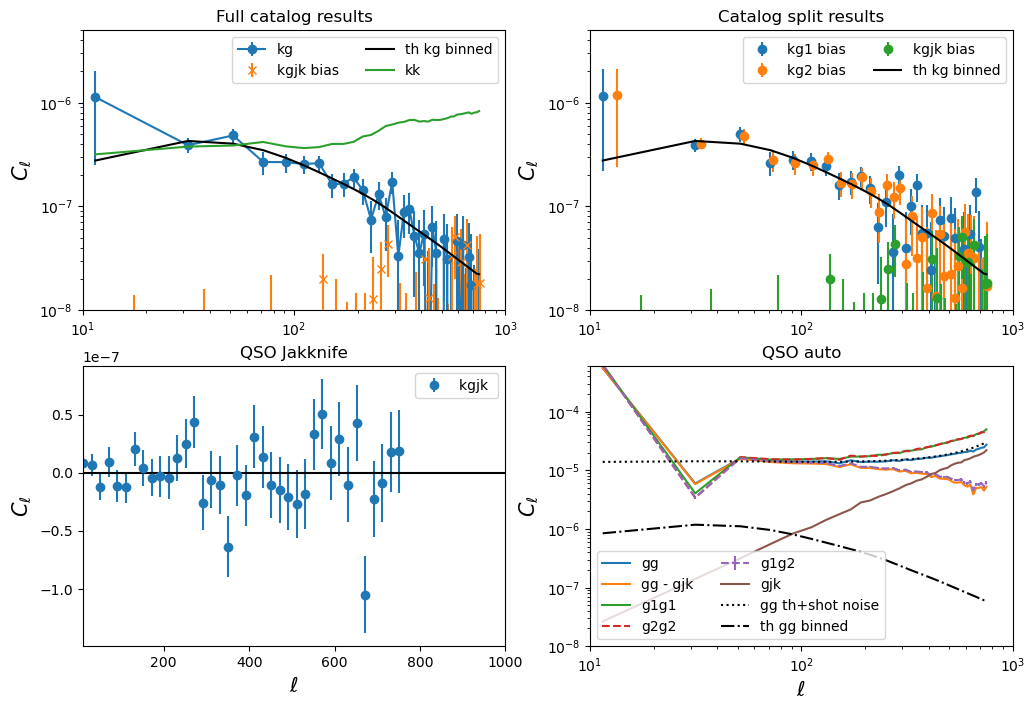

In [801]:
plot_summary(clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned)

In [586]:
len(d[1].data['redshift_spz'])

648842

# Power spectrum estimation PolSPICE


In [587]:
import ispice
from bin_llcl import bin_llcl

### Computation 

write fits file to conform to python wrapper

In [588]:
# write maps for polspice
hp.write_map('../../klr.fits',klr,overwrite=True)
hp.write_map('../../g.fits',c,overwrite=True)
hp.write_map('../../gsel.fits',csel,overwrite=True)
hp.write_map('../../g1.fits',c1,overwrite=True)
hp.write_map('../../g2.fits',c2,overwrite=True)
hp.write_map('../../gjk.fits',jk,overwrite=True)
hp.write_map('../../analysis_mask.fits',analysis_mask,overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Computes all auto and cross

In [589]:
# auto
ispice.ispice('../../klr.fits', '../../cl_klr.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')
ispice.ispice('../../g.fits', '../../cl_g.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')
ispice.ispice('../../g1.fits', '../../cl_g1.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')
ispice.ispice('../../g2.fits', '../../cl_g2.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')
ispice.ispice('../../gjk.fits', '../../cl_gjk.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_klr.fits -decouple NO -mapfile ../../klr.fits -fits_out YES -weightfile ../../analysis_mask.fits -nlmax -1 -normfac 1.0 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity NO -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 
 ===> HEALPIXDATA not defined, trying HEALPIX...
 ===> Using HEALPIXDATA=/Users/gfabbian/Software/Healpix_3.82/data/
 CPU  Time [s]:   0.491021037    
 Wall Time [s]:   0.125000000    
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_g.fits -decouple NO -mapfile ../../g.fits -fits_out YES -weightfile ../../analysis_mask.fit

0

In [590]:
# cross

ispice.ispice('../../klr.fits', '../../cl_kg.fits', covfileout='', mapfile2='../../g.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kg1.fits', covfileout='', mapfile2='../../g1.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kg2.fits', covfileout='', mapfile2='../../g2.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kgjk.fits', covfileout='', mapfile2='../../gjk.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')
ispice.ispice('../../g1.fits', '../../cl_g1g2.fits', covfileout='', mapfile2='../../g2.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_kg.fits -decouple NO -mapfile ../../klr.fits -mapfile2 ../../g.fits -fits_out YES -weightfile ../../analysis_mask.fits -weightfile2 ../../analysis_mask.fits -nlmax -1 -normfac 1.0 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity NO -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 
 ===> HEALPIXDATA not defined, trying HEALPIX...
 ===> Using HEALPIXDATA=/Users/gfabbian/Software/Healpix_3.82/data/
 CPU  Time [s]:   0.930104017    
 Wall Time [s]:   0.250000000    
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_kg1.fits -decouple NO -mapfile 

0

Bins the $C_\ell$s using the same binning. We assumed uniform binning to conform with what we did in NAMASTER. 

In [620]:
b_spice=np.arange(2,3*nside-1,20)
do_uniform = True
lb_spice,clkk_spice,dl,buf=bin_llcl(hp.read_cl('../../cl_klr.fits'),b_spice,uniform=do_uniform)
clgg_spice=bin_llcl(hp.read_cl('../../cl_g.fits'),b_spice,uniform=do_uniform)[1]
clg1g1_spice=bin_llcl(hp.read_cl('../../cl_g1.fits'),b_spice,uniform=do_uniform)[1]
clg2g2_spice=bin_llcl(hp.read_cl('../../cl_g2.fits'),b_spice,uniform=do_uniform)[1]
clgjk_spice=bin_llcl(hp.read_cl('../../cl_gjk.fits'),b_spice,uniform=do_uniform)[1]

clkg_spice=bin_llcl(hp.read_cl('../../cl_kg.fits'),b_spice,uniform=do_uniform)[1]
clkg1_spice=bin_llcl(hp.read_cl('../../cl_kg1.fits'),b_spice,uniform=do_uniform)[1]
clkg2_spice=bin_llcl(hp.read_cl('../../cl_kg2.fits'),b_spice,uniform=do_uniform)[1]
clkgjk_spice=bin_llcl(hp.read_cl('../../cl_kgjk.fits'),b_spice,uniform=do_uniform)[1]
clkg2_spice=bin_llcl(hp.read_cl('../../cl_kg2.fits'),b_spice,uniform=do_uniform)[1]

clg1g2_spice=bin_llcl(hp.read_cl('../../cl_g1g2.fits'),b_spice,uniform=do_uniform)[1]

clkk_spice_ivar=bin_llcl(hp.read_cl('../../cl_klr.fits'),b_spice,uniform=False)[1]
clkg_spice_ivar=bin_llcl(hp.read_cl('../../cl_kg.fits'),b_spice,uniform=False)[1]
clgg_spice_ivar=bin_llcl(hp.read_cl('../../cl_g.fits'),b_spice,uniform=False)[1]
clg1g2_spice_ivar=bin_llcl(hp.read_cl('../../cl_g1g2.fits'),b_spice,uniform=False)[1]

cl_gg_th_binned_spice=bin_llcl(cls['W1xW1'],b_spice,uniform=do_uniform)[1]
cl_kg_th_binned_spice=bin_llcl(cls['PxW1']*p2k,b_spice,uniform=do_uniform)[1]
cl_kk_th_binned_spice=bin_llcl(hp.alm2cl(klm),b_spice,uniform=do_uniform)[1]

lmin 31.5
kg snr 16.827300613544793 snr th 20.15107889828493
kg chi2 0.9428433069356043 PTE 0.5685628691238542
kg chi2 JK 1.0437523284326495 PTE 0.3963412344399674


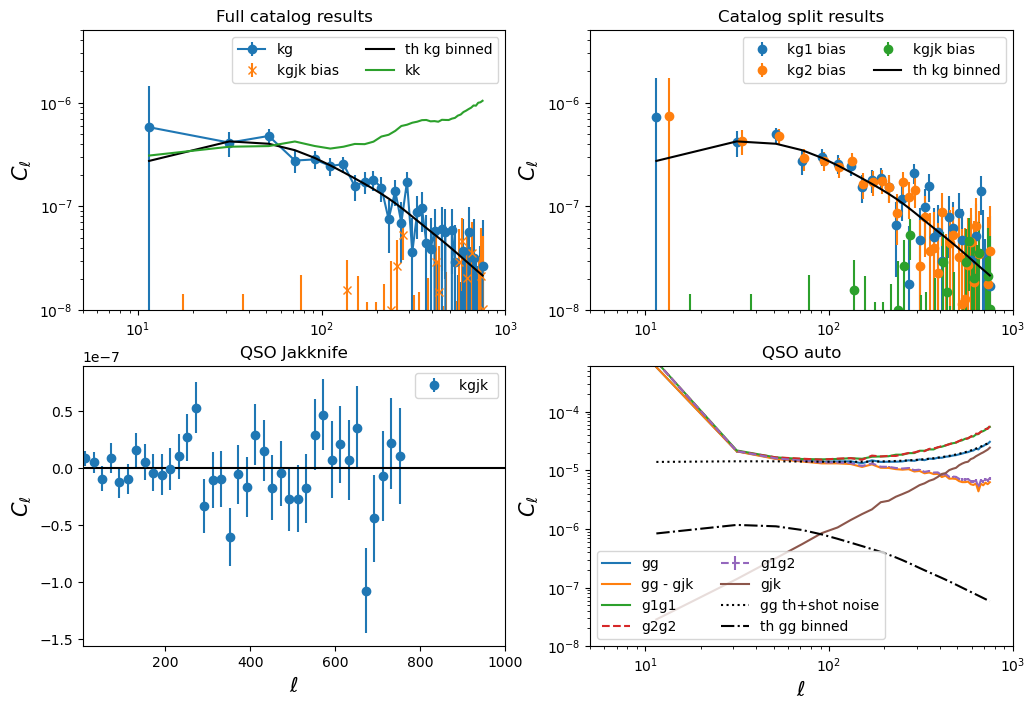

In [613]:
plot_summary(clkg_spice,clgg_spice,clkk_spice,clkg1_spice,clg1g1_spice,clkg2_spice,clg2g2_spice,clg1g2_spice,
             clkgjk_spice,clgjk_spice,cl_gg_th_binned_spice,cl_kg_th_binned_spice,cl_kk_th_binned_spice,
             lb=lb_spice,delta_b=dl,lmin=5)

### Method comparison

For the cross-correlation, the points are essentially the same except for the first 1 or 2 bin if we adopt the same binning scheme (i.e. not weighting the multipoles by $1/(2\ell+1)$ that would give an inverse variance weight).

The inverse variance weight lowers the value of the first bin and in particular in the galaxy auto spectrum things improve. We need to optimize the large scale estimation.

SPICE seems to handle better the largest scales when the mask is complicated (i.e. when using the native one). 

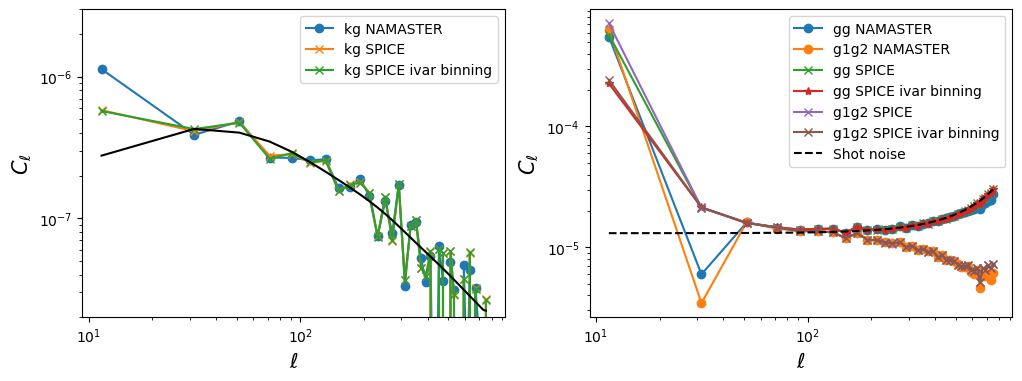

In [621]:
pl.figure(figsize=(12,4))

pl.subplot(1,2,1)
pl.errorbar(lb,clkg,marker='o',label='kg NAMASTER')
pl.errorbar(lb_spice,clkg_spice,marker='x',label='kg SPICE')
pl.errorbar(lb_spice,clkg_spice_ivar,marker='x',label='kg SPICE ivar binning')
pl.errorbar(lb,cl_kg_th_binned,color='black')
pl.xscale('log')
pl.yscale('log')
pl.ylim(2e-08,3e-06)
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.legend()
pl.subplot(1,2,2)
pl.errorbar(lb,clgg,marker='o',label='gg NAMASTER')
pl.errorbar(lb,clg1g2,marker='o',label='g1g2 NAMASTER')
pl.errorbar(lb_spice,clgg_spice,marker='x',label='gg SPICE')
pl.errorbar(lb_spice,clgg_spice_ivar,marker='*',label='gg SPICE ivar binning')
pl.errorbar(lb,clg1g2_spice,marker='x',label='g1g2 SPICE')
pl.errorbar(lb,clg1g2_spice_ivar,marker='x',label='g1g2 SPICE ivar binning')
shot_noise = (lb_spice*hp.nside2resol(nside)**2*1/nbar/lb_spice)/beam[lb_spice.astype(np.int32)]**2
pl.errorbar(lb_spice,shot_noise,ls='--',color='black',label='Shot noise')
pl.xscale('log')
pl.yscale('log')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.legend()
pl.show()

# Selection function  effects 

Stor map and recompute power spectra on a ask where the selection function correction is defined.

In [595]:
hp.write_map('../../apodized_mask_kate.fits',apomask,overwrite=True)

setting the output map dtype to [dtype('float64')]


In [596]:
f0 = nmt.NmtField(apomask, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f0, f0, b)

fcsel = nmt.NmtField(apomask, [csel],beam=beam) # corrects for pixel window as klr computed from downgrade

fc = nmt.NmtField(apomask, [c],beam=beam) # corrects for pixel window as klr computed from downgrade
clkk_csel = compute_master(f0,f0,w)[0]
clkg_csel = compute_master(f0,fcsel,w)[0]
clgg_csel = compute_master(fcsel,fcsel,w)[0]
clkg_c = compute_master(f0,fc,w)[0]
clgg_c = compute_master(fc,fc,w)[0]

# do the cross with spice
ispice.ispice('../../klr.fits', '../../cl_klr_apomask.fits', weightfile1='../../apodized_mask_kate.fits',
              verbosity='NO')
ispice.ispice('../../gsel.fits', '../../cl_gsel_apomask.fits', weightfile1='../../apodized_mask_kate.fits',
              verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kgsel_apomask.fits', covfileout='', mapfile2='../../gsel.fits', 
              weightfile1='../../apodized_mask_kate.fits', weightfile2='../../apodized_mask_kate.fits',
              verbosity='NO')
ispice.ispice('../../g.fits', '../../cl_g_apomask.fits', weightfile1='../../apodized_mask_kate.fits',
              verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kg_apomask.fits', covfileout='', mapfile2='../../g.fits', 
              weightfile1='../../apodized_mask_kate.fits', weightfile2='../../apodized_mask_kate.fits',
              verbosity='NO')


b_spice=np.arange(2,3*nside-1,20)
do_uniform = True
lb_spice,clkk_spice_csel,dl,buf=bin_llcl(hp.read_cl('../../cl_klr_apomask.fits'),b_spice,uniform=do_uniform)
clgg_spice_csel=bin_llcl(hp.read_cl('../../cl_gsel_apomask.fits'),b_spice,uniform=do_uniform)[1]
clgg_spice_c=bin_llcl(hp.read_cl('../../cl_g_apomask.fits'),b_spice,uniform=do_uniform)[1]
clkg_spice_csel=bin_llcl(hp.read_cl('../../cl_kgsel_apomask.fits'),b_spice,uniform=do_uniform)[1]
clkg_spice_c=bin_llcl(hp.read_cl('../../cl_kg_apomask.fits'),b_spice,uniform=do_uniform)[1]


Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_klr_apomask.fits -decouple NO -mapfile ../../klr.fits -fits_out YES -weightfile ../../apodized_mask_kate.fits -nlmax -1 -normfac 1.0 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity NO -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 
 ===> HEALPIXDATA not defined, trying HEALPIX...
 ===> Using HEALPIXDATA=/Users/gfabbian/Software/Healpix_3.82/data/
 CPU  Time [s]:   0.439445019    
 Wall Time [s]:   0.250000000    
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_gsel_apomask.fits -decouple NO -mapfile ../../gsel.fits -fits_out YES -weightf

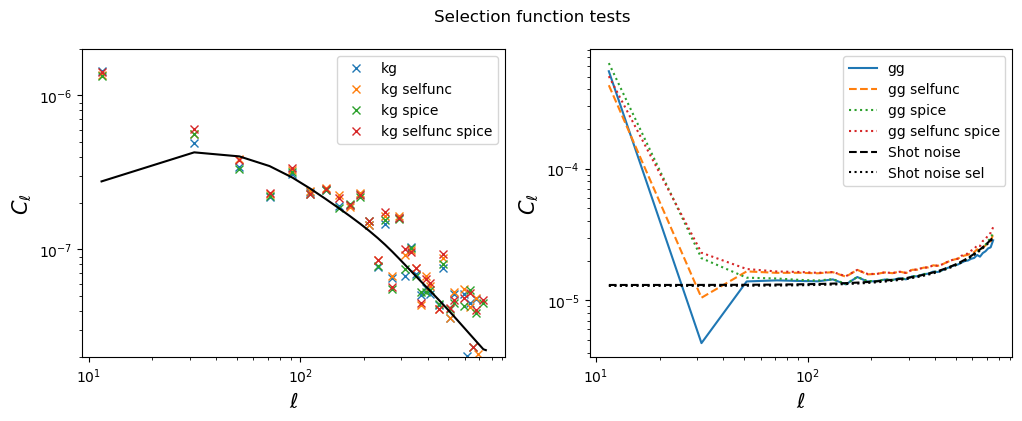

In [624]:
pl.figure(figsize=(12,4))
pl.subplot(121)
pl.loglog(lb,clkg_c,label='kg',ls='',marker='x')
pl.loglog(lb,clkg_csel,label='kg selfunc',ls='',marker='x')
pl.loglog(lb,clkg_spice_c,label='kg spice',ls='',marker='x')
pl.loglog(lb,clkg_spice_csel,label='kg selfunc spice',ls='',marker='x')
pl.loglog(lb,cl_kg_th_binned,color='black')
pl.ylim(2e-08,2e-06)
pl.legend()
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.subplot(122)
pl.loglog(lb,clgg_c,label='gg')
pl.loglog(lb,clgg_csel,label='gg selfunc',ls='--')
pl.loglog(lb,clgg_spice_c,label='gg spice',ls=':')
pl.loglog(lb,clgg_spice_csel,label='gg selfunc spice',ls=':')
pl.errorbar(lb_spice,shot_noise,ls='--',color='black',label='Shot noise')

shot_noise_sel = (lb_spice*hp.nside2resol(nside)**2*1/nbar_sel/lb_spice)/beam[lb_spice.astype(np.int32)]**2
pl.errorbar(lb_spice,shot_noise_sel,ls=':',color='black',label='Shot noise sel')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.legend()
pl.suptitle("Selection function tests")
pl.show()

# Summary

We need to implement inverse variance weighting in the pseudo-$C_\ell$ as it seems to perform better for SPICE. The mask is nasty and we need to introduce some tapering that is effective on both methods. We see oscillations of fracitons of sigma at $\ell\gtrsim 50$. Small scales seem to be relatively under control but anything below 50 requires some attention. 

The auto spectrum of QSO dominated by shot noise and and displays a big excess of power in the first bin that we need to address. As it is so noise dominated is likely not having any constraining power. 
The behavior of the first 2 bin is somehow sensitive to the mask choice and power spectrum estimator. 

# Tomography

We can repeat a similar analysis splitting the sample in 4 equally populated redshift bins. The splitting gives sub-samples with the following properties.

bounds tomographic bins [0, 0.9440646171569824, 1.447939, 1.974499, 4.54]
effective median redhisfts 0.6200702520427703 1.201 1.6849333047866821 2.383
effective mean redhisfts 0.59904534876775 1.2025720962418147 1.6933676386481 2.4737030208453596


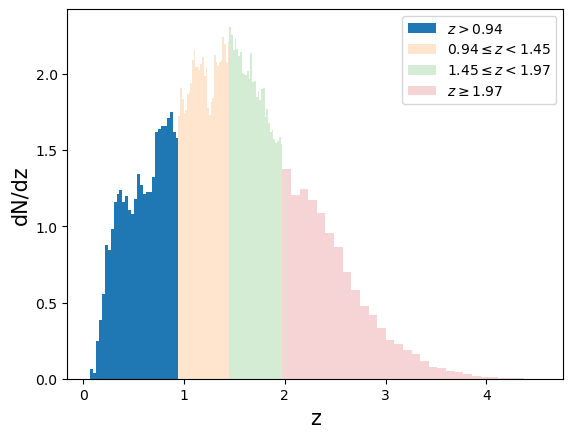

In [951]:
z=d[1].data['redshift_spz']
bounds = np.percentile(z,[25,50,75])

#np.percentile(d[1].data['redshift_spz'],[33,66])
print("bounds tomographic bins",[0]+list(bounds)+[np.max(z)])
print("effective median redhisfts",np.median(z[mask_z1]),np.median(z[mask_z2]),np.median(z[mask_z3]),
      np.median(z[mask_z4]))
print("effective mean redhisfts",np.mean(z[mask_z1]),np.mean(z[mask_z2]),np.mean(z[mask_z3]),
      np.mean(z[mask_z4]))

z=d[1].data['redshift_spz']
dndz1=pl.hist(z[mask_z1],bins=30,density=True,label=          '$z>%.2f$'%bounds[0])
dndz2=pl.hist(z[mask_z2],bins=30,density=True,alpha=0.2,label='$%.2f\leq z<%.2f$'%(bounds[0],bounds[1]))
dndz3=pl.hist(z[mask_z3],bins=30,density=True,alpha=0.2,label='$%.2f\leq z<%.2f$'%(bounds[1],bounds[2]))
dndz4=pl.hist(z[mask_z4],bins=30,density=True,alpha=0.2,label='$z\geq %.2f$'%bounds[-1])
pl.xlabel("z",size=15)
pl.ylabel("dN/dz",size=15)
pl.legend()
pl.show()

In [947]:
# compute dndz

dndz1=[np.diff(dndz1[1])/2+dndz1[1][:-1],dndz1[0]]
dndz2=[np.diff(dndz2[1])/2+dndz2[1][:-1],dndz2[0]]
dndz3=[np.diff(dndz3[1])/2+dndz3[1][:-1],dndz3[0]]
dndz4=[np.diff(dndz4[1])/2+dndz4[1][:-1],dndz4[0]]
dndz1[1]/=np.trapz(dndz1[1],dndz1[0])
dndz2[1]/=np.trapz(dndz2[1],dndz2[0])
dndz3[1]/=np.trapz(dndz3[1],dndz3[0])
dndz4[1]/=np.trapz(dndz4[1],dndz4[0])


Using the $dN/dz$ of all the samples we compute the theory curves expected from the sample. We assume the same effective bias as for the full sample

In [899]:
##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.

pars1=init_pars()
W1=np.array(dndz1[1])
z1=np.array(dndz1[0])
pars1.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z1)), z=z1, W=W1,source_type='counts')]
results1 = camb.get_results(pars1)
cls1 = results1.get_source_cls_dict(raw_cl=True) 

pars2=init_pars()
W2=np.array(dndz2[1])
z2=np.array(dndz2[0])
pars2.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z2)), z=z2, W=W2,source_type='counts')]
results2= camb.get_results(pars2)
cls2 = results2.get_source_cls_dict(raw_cl=True) 

pars3=init_pars()
W3=np.array(dndz3[1])
z3=np.array(dndz3[0])
pars3.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z3)), z=z3, W=W3,source_type='counts')]
results3 = camb.get_results(pars3)
cls3 = results3.get_source_cls_dict(raw_cl=True) 

pars4=init_pars()
W4=np.array(dndz4[1])
z4=np.array(dndz4[0])
pars4.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z4)), z=z4, W=W4,source_type='counts')]
results4 = camb.get_results(pars4)
cls4 = results4.get_source_cls_dict(raw_cl=True) 




The maps are computed following the steps used for the full sample

In [948]:

mask_z1 = z<bounds[0]
mask_z2 = (z>=bounds[0])&(z<bounds[1])
mask_z3 = (z>=bounds[1])&(z<bounds[2])
mask_z4 = z>=bounds[2]

mz1 = make_counts(nside,gs.l.value[mask_z1],gs.b.value[mask_z1])
mz2 = make_counts(nside,gs.l.value[mask_z2],gs.b.value[mask_z2])
mz3 = make_counts(nside,gs.l.value[mask_z3],gs.b.value[mask_z3])
mz4 = make_counts(nside,gs.l.value[mask_z4],gs.b.value[mask_z4])

nbar_z1 = np.mean(mz1[binmask!=0])
nbar_z2 = np.mean(mz2[binmask!=0])
nbar_z3 = np.mean(mz3[binmask!=0])
nbar_z4 = np.mean(mz4[binmask!=0])

cz1 = mz1/nbar_z1- 1
cz2 = mz2/nbar_z2- 1
cz3 = mz3/nbar_z3- 1
cz4 = mz4/nbar_z4- 1
print("nbar full",nbar)
print("nbar zbins",nbar_z1,nbar_z2,nbar_z3,nbar_z4)

nbar full 1.2225455565615475
nbar zbins 0.29384970479093075 0.3041176245552736 0.306785345388235 0.31779288182710824


In [900]:
f0 = nmt.NmtField(apomask_gal50, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f0, f0, b)

clkk_cz = compute_master(f0,f0,w)[0]
clkg_cz=[]
clgg_cz=[]

clgg_th_z = [cls1['W1xW1'],cls2['W1xW1'],cls3['W1xW1'],cls4['W1xW1'],cls['W1xW1']]
clkg_th_z = [cls1['PxW1']*p2k,cls2['PxW1']*p2k,cls3['PxW1']*p2k,cls4['PxW1']*p2k,cls['W1xW1']]

cl_gg_thcz_binned = []
cl_kg_thcz_binned = []

    

for i,cmap in enumerate([cz1,cz2,cz3,cz4,c]):
    fcz = nmt.NmtField(apomask_gal50, [cmap],beam=beam) # corrects for pixel window as klr computed from downgrade

    clkg_cz.append( compute_master(f0,fcz,w)[0])
    clgg_cz.append( compute_master(fcz,fcz,w)[0])
    
    cl_gg_thcz_binned.append(w.decouple_cell(w.couple_cell([clgg_th_z[i]]))[0])
    cl_kg_thcz_binned.append(w.decouple_cell(w.couple_cell([clkg_th_z[i]]))[0])    

### Results 

Here we plot the results. We rescaled roughly the bias of each redshift bin following the data in figure 3 of https://arxiv.org/abs/1809.04196. 

The computation of the theory curves with CAMB has problems at hight redshift  and at the largest scale but the rough rescaling we applied seems to describe the data reasonably well. We have assumed a redshift independent bias within the bin. The lowest $z$ bin seems to agree well with theory even at large scales, while the first bin at higher redshift is marginally more off. 

Note that compare to the paper we quoted earlier we have a much higher detection significance and we extend the redshift range (the old eBOSS quasar had $0.9<z<2.2$. 

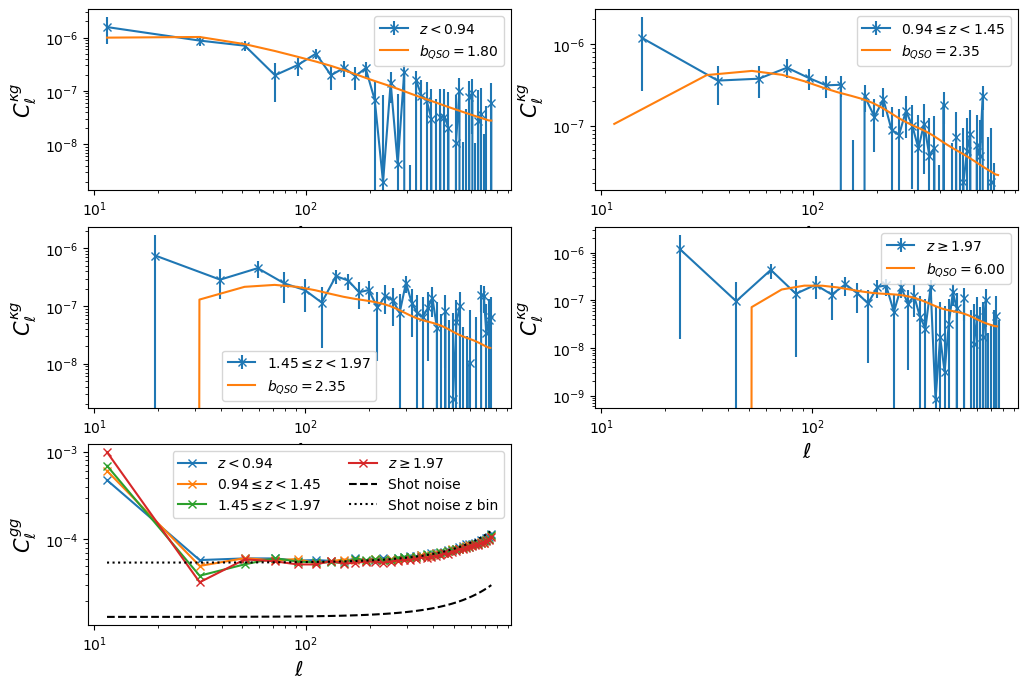

In [949]:
zlabels=['$z<%.2f$'%bounds[0],'$%.2f\leq z<%.2f$'%(bounds[0],bounds[1]),'$%.2f\leq z<%.2f$'%(bounds[1],bounds[2]),
'$z\geq %.2f$'%bounds[-1],'$z<z_{max}$']

plotid=320
bias_rescaling=[1.8/b_quasar,1,1,6./b_quasar]

pl.figure(figsize=(12,8))

for i,clkg_czi in enumerate(clkg_cz[:-1]):
    pl.subplot(int(plotid+i+1))
    #errorbar
    dki_z1 = np.sqrt(clkk_cz*clgg_cz[i] + clkg_czi**2)/np.sqrt((2*lb+1)*delta_b*np.mean(apomask_gal50))
    pl.errorbar(lb+4*i,clkg_czi,yerr=dki_z1,ls='-',marker='x',label=zlabels[i])
    pl.errorbar(lb,bias_rescaling[i]*cl_kg_thcz_binned[i],ls='-',
                marker='',label='$b_{QSO}=%.2f$'%(b_quasar*bias_rescaling[i]))
    #pl.errorbar(lb,cl_kg_thcz_binned[i],ls='-',marker='')
#pl.errorbar(lb,clgg_cz[-1],ls='-',marker='x',label=zlabels[i])
#pl.errorbar(lb,cl_kg_th_binned,color='black')
#pl.ylim(2e-08,2e-06)
    pl.legend()
    pl.xscale('log')
    pl.yscale('log')    
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C^{\kappa g}_\ell$',size=15)

#pl.show()

pl.subplot(325)
for i,clgg_czi in enumerate(clgg_cz[:-1]):
    pl.errorbar(lb,clgg_czi,ls='-',marker='x',label=zlabels[i])

#pl.errorbar(lb,cl_gg_th_binned,color='black')
pl.errorbar(lb_spice,shot_noise,ls='--',color='black',label='Shot noise')
pl.errorbar(lb_spice,shot_noise*nbar/nbar_z1,ls=':',color='black',label='Shot noise z bin')

pl.xlabel('$\ell$',size=15)
pl.ylabel('$C^{gg}_\ell$',size=15)
pl.legend(loc='best',ncol=2)
pl.xscale('log')
pl.yscale('log')
pl.show()

In [950]:
print(np.median(z[z>2]))
print(np.median(z[z<0.94]))

2.4
0.617


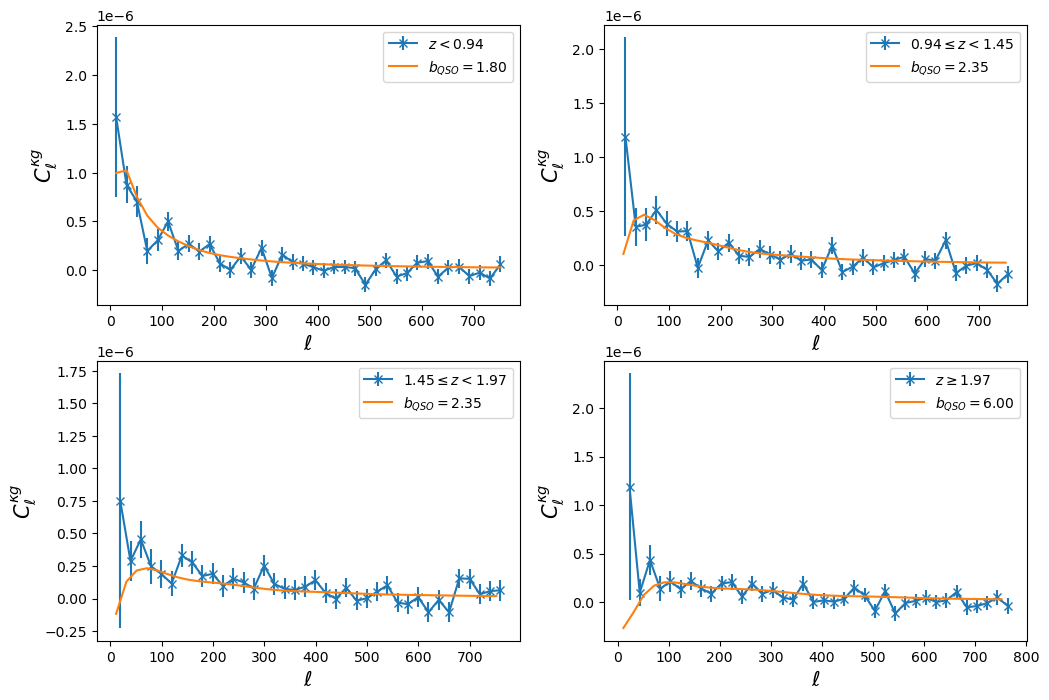

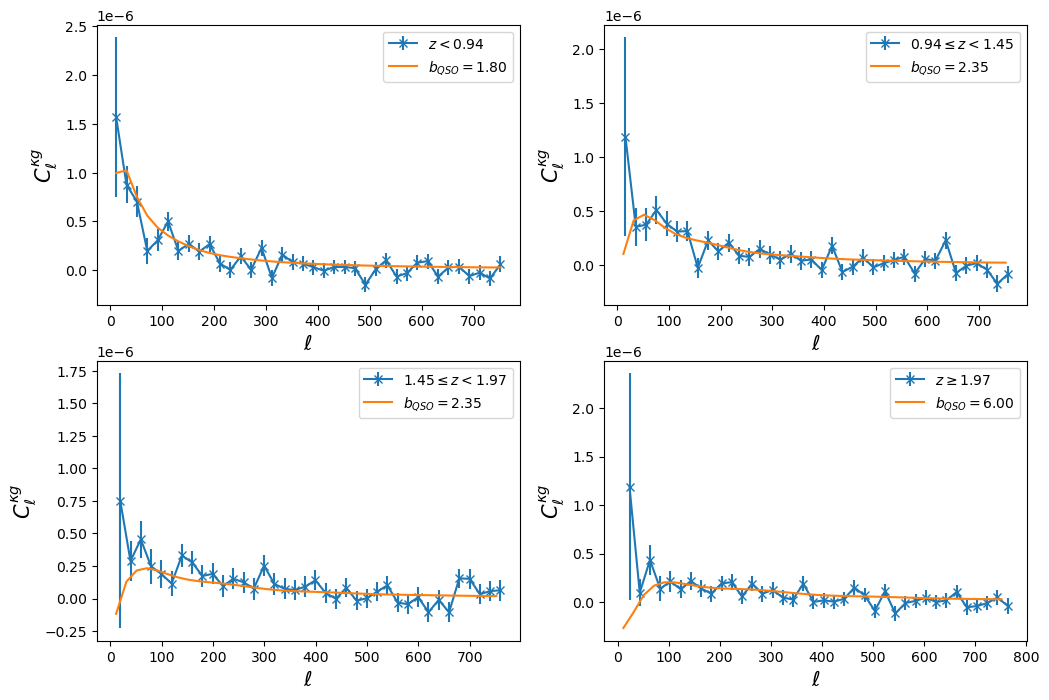

In [953]:
zlabels=['$z<%.2f$'%bounds[0],'$%.2f\leq z<%.2f$'%(bounds[0],bounds[1]),'$%.2f\leq z<%.2f$'%(bounds[1],bounds[2]),
'$z\geq %.2f$'%bounds[-1],'$z<z_{max}$']

plotid=220
bias_rescaling=[1.8/b_quasar,1,1,6./b_quasar]

pl.figure(figsize=(12,8))

for i,clkg_czi in enumerate(clkg_cz[:-1]):
    pl.subplot(int(plotid+i+1))
    #errorbar
    dki_z1 = np.sqrt(clkk_cz*clgg_cz[i] + clkg_czi**2)/np.sqrt((2*lb+1)*delta_b*np.mean(apomask_gal50))
    pl.errorbar(lb+4*i,clkg_czi,yerr=dki_z1,ls='-',marker='x',label=zlabels[i])
    pl.errorbar(lb,bias_rescaling[i]*cl_kg_thcz_binned[i],ls='-',
                marker='',label='$b_{QSO}=%.2f$'%(b_quasar*bias_rescaling[i]))
    #pl.errorbar(lb,cl_kg_thcz_binned[i],ls='-',marker='')
#pl.errorbar(lb,clgg_cz[-1],ls='-',marker='x',label=zlabels[i])
#pl.errorbar(lb,cl_kg_th_binned,color='black')
#pl.ylim(2e-08,2e-06)
    pl.legend()
    #pl.xscale('log')
    #pl.yscale('log')    
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C^{\kappa g}_\ell$',size=15)
pl.show()